In [24]:
import random
import numpy as np
import networkx as nx 
from dijkstar import Graph, find_path
from ipywidgets import IntProgress 
from IPython.display import display
import matplotlib.pyplot as plt

In [25]:
def get_complete_path(path, all_paths):
  complete_path = []
  for i in range(len(path) - 1):
    complete_path.extend(all_paths[(path[i], path[i+1])][:-1])
    if i == len(path) - 2:
      complete_path.append(all_paths[(path[i], path[i+1])][-1])
  return complete_path

def is_path_in_interval(path, complete_graph, interval, interval_vertex):
  weight = 0
  for i in range(np.where(np.array(path) == interval_vertex)[0][0]):
    weight += complete_graph[path[i]][path[i+1]]
  if weight >= interval[0] and weight <= interval[1]:
    return True
  else:
    return False

In [26]:
population_number = 5000
generation_number = 200

In [27]:
def get_path_weight(path, complete_graph):
  weight = 0
  for i in range(len(path) - 1):
    weight += complete_graph[path[i]][path[i+1]]
  return weight

def generate_population(nb_people, complete_graph, interval, interval_vertex, start_vertex):
  population = []
  while(len(population) < nb_people):
    path = generate_random_path(len(complete_graph), start_vertex)
    if is_path_in_interval(path, complete_graph, interval, interval_vertex):
      population.append(path)
  return population

def get_best_path(population, weights):
  index = np.argmin(weights)
  return population[index], weights[index]


In [28]:
def mutate_path_insert(path, complete_graph, interval, interval_vertex):
  is_path_correct = False
  while not is_path_correct:
    start = path[0]
    path = np.delete(path, np.where(path == start))
    mutation = random.choice(path)
    path = np.delete(path, np.where(path == mutation))
    new_index = random.randint(0, len(path) - 1)
    path = np.insert(path, new_index, mutation)
    path = np.append(path, start)
    path = np.insert(path, 0, start)
    is_path_correct = is_path_in_interval(path, complete_graph, interval, interval_vertex)
  return path

def generate_children(parentA, parentB, complete_graph, interval, interval_vertex):
  start = parentA[0]
  parentA = np.delete(parentA, np.where(np.array(parentA) == start))
  parentB = np.delete(parentB, np.where(np.array(parentB) == start))
  is_path_correct = False
  while not is_path_correct:
    cut_start = random.randint(0, len(parentA) - 2)
    cut_end = random.randint(cut_start + 1, len(parentA) - 1)
    child = parentA[cut_start:cut_end]
    for i in child:
      remaining_parentB = np.delete(parentB, np.where(parentB == i))
    child = np.insert(child, len(child), remaining_parentB)
    child = np.append(child, start)
    child = np.insert(child, 0, start)
    is_path_correct = is_path_in_interval(child, complete_graph, interval, interval_vertex)
  return child

def generate_random_path(nb_vertex, start_vertex):
  path = np.arange(nb_vertex)
  path = np.delete(path, np.where(path == start_vertex))
  np.random.shuffle(path)
  path = np.append(path, start_vertex)
  path = np.insert(path, 0, start_vertex)
  return path

def get_best_population(population):
  return np.argpartition(population, -int(len(population)/4))[:int(len(population)/4)]

def generate_decency(population_number, best_people, complete_graph, interval, interval_vertex_index):
  children = []
  for _ in range(population_number):
    P1 = random.choice(best_people)
    # child = generate_children(P1, P2, complete_graph, interval, interval_vertex_index)
    child = mutate_path_insert(P1, complete_graph, interval, interval_vertex_index)
    children.append(child)
  return children

def evalute_population_weight(population, complete_graph):
  weights = []
  for path in population:
    weight = get_path_weight(path, complete_graph)
    weights.append(weight)
  return weights

def evolve(population, complete_graph, interval, interval_vertex_index):
  best_weight = np.inf
  best_path = []
  all_best_weights = np.array([])
  bar = IntProgress(min=0, max=generation_number, layout={"width" : "100%"})
  display(bar)
  for i in range(generation_number):
    bar.value += 1
    weights = evalute_population_weight(population, complete_graph)
    best_pop_path, best_pop_weight = get_best_path(population, weights)
    all_best_weights = np.append(all_best_weights,best_pop_weight)
    if(best_pop_weight < best_weight):
      best_weight = best_pop_weight
      best_path = best_pop_path
    best_people = np.array(population)[get_best_population(weights)]
    population = generate_decency(population_number, best_people, complete_graph, interval, interval_vertex_index)
  bar.close()
  return best_path, best_weight, all_best_weights

def plot_graph(path, graph, all_vertex, all_verticies, start_vertex):
  for i in range(len(graph) - 1):
    for j in range(i + 1, len(graph)):
      if graph[i, j] != np.inf:
        x = [all_vertex[i][0], all_vertex[j][0]]
        y = [all_vertex[i][1], all_vertex[j][1]]
        plt.plot(x, y, color = "gray")
  for i in range(len(path) - 1):
    x = [all_vertex[path[i]][0], all_vertex[path[i+1]][0]]
    y = [all_vertex[path[i]][1], all_vertex[path[i+1]][1]]
    plt.plot(x, y, color = "red")
  for i in range(len(all_vertex)):
    if(i == start_vertex):
      plt.scatter(all_vertex[i][0], all_vertex[i][1], color = "blue")
    elif(i in all_verticies):
      plt.scatter(all_vertex[i][0], all_vertex[i][1], color = "green")
    else: 
      plt.scatter(all_vertex[i][0], all_vertex[i][1], color = "gray")
    plt.text(all_vertex[i][0] - 10, all_vertex[i][1] + 20, str(i))
  plt.show()

In [29]:
import pickle
with open("data_small.pickle", "rb") as file:
  data = pickle.load(file)

graph = data["graph"]
complete_graph = data["complete_graph"]
all_paths = data["all_paths"]
vertices_list = data["vertices_list"]
start_vertex = data["start_vertex"]
start_vertex_index = data["start_vertex_index"]
interval_vertex = data["interval_vertex"]
interval_vertex_index = data["interval_vertex_index"]
interval = data["interval"]
all_vertex = data["all_vertex"]

population = generate_population(population_number, complete_graph, interval, interval_vertex_index, start_vertex_index)
best_path, best_weight, all_best_weights = evolve(population, complete_graph, interval, interval_vertex_index)
print(best_path, best_weight)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

[36 44 12  6 34  1 38 19 48 10 18 47 43  0 33 25 14 32  4 13 21  5 16 49
  8 41 27 39 46 11  2 31 45 37 24 23  9 35 26  3 40 17 29 30  7 15 20 42
 28 22 36] 12830.11397774324


[92, 11, 56, 98, 3, 38, 69, 20, 33, 15, 33, 68, 13, 72, 27, 65, 77, 71, 73, 74, 50, 31, 46, 85, 48, 52, 17, 52, 42, 0, 23, 61, 2, 47, 30, 9, 43, 28, 31, 54, 25, 27, 62, 1, 86, 26, 65, 5, 58, 77, 79, 66, 75, 10, 91, 89, 11, 8, 95, 67, 92, 89, 11, 95, 70, 64, 84, 14, 45, 29, 7, 29, 36, 49, 92]


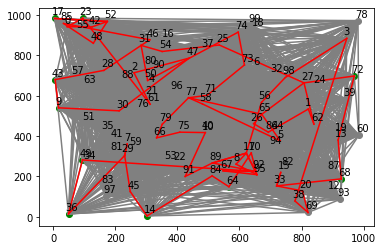

In [30]:
complete_path = get_complete_path(best_path, all_paths)
print(complete_path)
plot_graph(complete_path, graph, all_vertex, vertices_list, start_vertex)

Text(0, 0.5, 'weight')

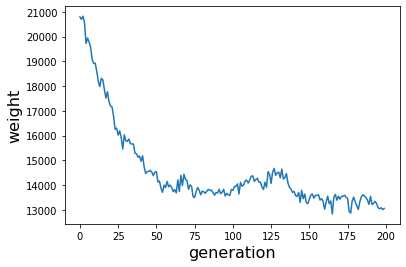

In [31]:
import matplotlib.pyplot as plt

res = plt.plot(range(len(all_best_weights)), all_best_weights)
plt.xlabel("generation", fontsize=16)
plt.ylabel("weight", fontsize=16)